<a href="https://colab.research.google.com/github/arturomf94/ce-mia/blob/master/tarea3/genetic_algorithm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [41]:
!pip install deap

In [0]:
import math
import random
from deap import creator, base, tools, algorithms
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
import numpy as np

In [0]:
# get length of binary representation given bounds and precision
def bin_len(lim_inf, lim_sup, pre):
  return int(math.log2((lim_sup - lim_inf) * 10 ** pre) + 0.9)

# return decimal given binary list and bounds
def decimalize(bin_list, lim_inf, lim_sup):
  bin_number = ''.join(str(e) for e in bin_list)
  bin_int = int(bin_number, 2)
  return lim_inf + (bin_int * (lim_sup - lim_inf) / (2 ** L - 1))

In [0]:
### I

## parameters: 

lim_inf = -10
lim_sup = 10
pre = 3
L = bin_len(lim_inf, lim_sup, pre) # length of binary rep for one x_i
D = 10
N = D * L # length of total potential solution in binary representation


## objective function

def obj(ind):
  result = 0
  for i in ind:
    result += i**2
  return result

In [0]:
def f(x, y):
    return x ** 2 + y ** 2
  
x = np.linspace(-6, 6, 30)
y = np.linspace(-6, 6, 30)
X, Y = np.meshgrid(x, y)
Z = f(X, Y)
fig = plt.figure(figsize = (20,15))
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
ax.set_title('surface');


In [0]:
# stochastic remainder selection (no replacement) for minimzation
from operator import attrgetter

def srnr(individuals):
  average_fit = sum(getattr(ind, 'fitness').values[0] for ind in individuals) / len(individuals)
  selected = []
  ascending_individuals = tools.selWorst(individuals, len(individuals))
  descending_individuals = tools.selBest(individuals, len(individuals))
  for i in range(len(individuals)):
    asc_ind = ascending_individuals[i]
    des_ind = descending_individuals[i]
    asc_ind.fitness.expected_value = des_ind.fitness.values[0] / average_fit
    asc_ind.fitness.expected_value_integer = math.floor(asc_ind.fitness.expected_value)
    asc_ind.fitness.expected_value_remainder = asc_ind.fitness.expected_value - asc_ind.fitness.expected_value_integer
    selected = selected + [asc_ind] * asc_ind.fitness.expected_value_integer
  i = 0
  while len(selected) < len(ascending_individuals):
    index = i % len(ascending_individuals)
    if random.random() < ascending_individuals[index].fitness.expected_value_remainder:
      selected.append(ascending_individuals[index])
    i += 1
  return selected

In [46]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()

toolbox.register("attr_bool", random.randint, 0, 1)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n = N)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

def evalOneMax(individual):
    decimal_representation = []
    for i in range(1, D + 1):
      lower_index = (i - 1) * L
      higher_index = i * L
      x = decimalize(individual[lower_index:higher_index], lim_inf, lim_sup)
      decimal_representation.append(x)
    return obj(decimal_representation),

toolbox.register("evaluate", evalOneMax)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.1)
toolbox.register("select", srnr)

population = toolbox.population(n=300)

NGEN=500
for gen in range(NGEN):
    offspring = algorithms.varAnd(population, toolbox, cxpb=0.5, mutpb=0.1)
    fits = toolbox.map(toolbox.evaluate, offspring)
    for fit, ind in zip(fits, offspring):
        ind.fitness.values = fit
    population = toolbox.select(offspring)    
    # apply elitism
    if gen > 0: 
      population = best_individual + population[:(len(population) - 1)]
    best_individual = tools.selBest(population, k=1)
    print('Gen ' + str(gen))
    print(best_individual[0])
    print(best_individual[0].fitness.values[0])
top10 = tools.selBest(population, k=10)

/usr/local/lib/python3.6/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.6/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


In [0]:
### II

## parameters: 

lim_inf = -5.2
lim_sup = 5.2
D = 10
N = 10


## objective function

def obj(ind):
  result = 10 * D
  for i in ind:
    result += (i**2 - 10 * math.cos(2 * math.pi * i))
  return result

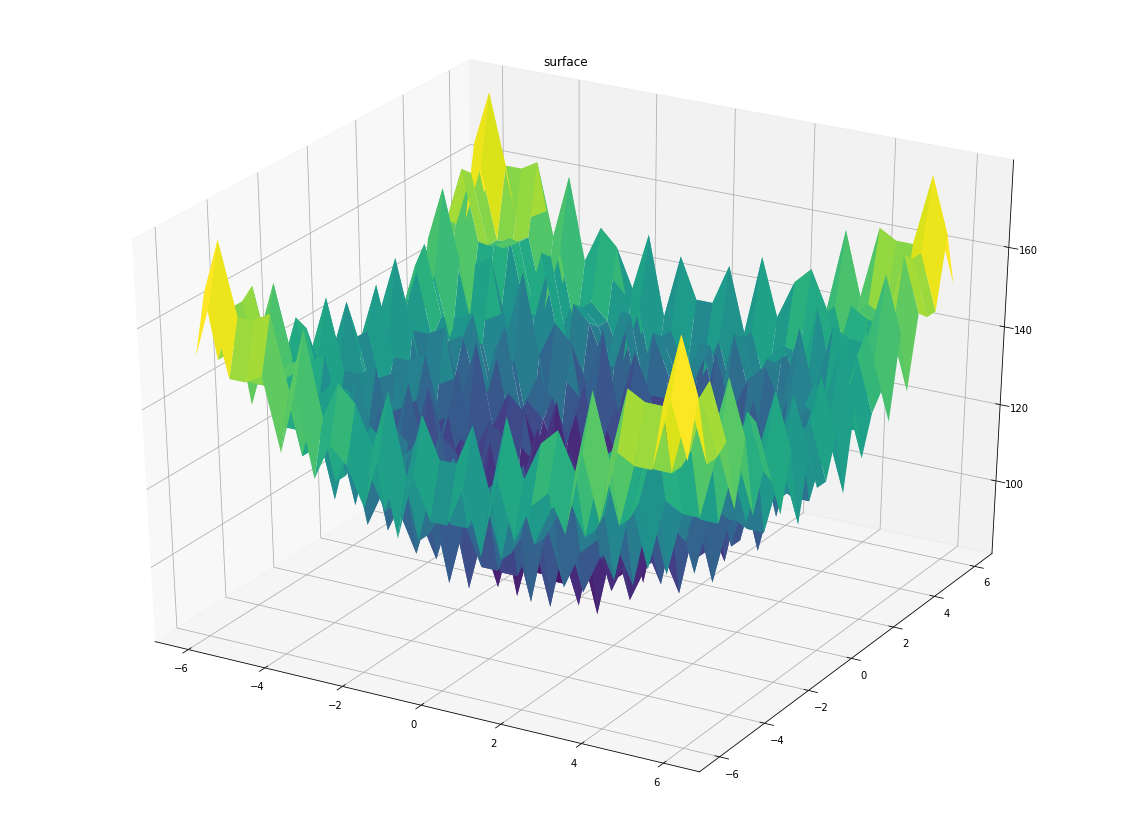

In [69]:
def f(x, y):
    return 10 * D + x ** 2 + y ** 2 - 10 * np.cos(2 * np.pi * x) - 10 * np.cos(2 * np.pi * y)
  
x = np.linspace(-6, 6, 30)
y = np.linspace(-6, 6, 30)
X, Y = np.meshgrid(x, y)
Z = f(X, Y)
fig = plt.figure(figsize = (20,15))
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
ax.set_title('surface');

In [0]:
from collections import Sequence
from itertools import repeat

def mutUniformFloat(individual, low, up, indpb):
    """Mutate an individual by replacing attributes, with probability *indpb*,
    by a integer uniformly drawn between *low* and *up* inclusively.
    :param individual: :term:`Sequence <sequence>` individual to be mutated.
    :param low: The lower bound or a :term:`python:sequence` of
                of lower bounds of the range from wich to draw the new
                integer.
    :param up: The upper bound or a :term:`python:sequence` of
               of upper bounds of the range from wich to draw the new
               integer.
    :param indpb: Independent probability for each attribute to be mutated.
    :returns: A tuple of one individual.
    """
    size = len(individual)
    if not isinstance(low, Sequence):
        low = repeat(low, size)
    elif len(low) < size:
        raise IndexError("low must be at least the size of individual: %d < %d" % (len(low), size))
    if not isinstance(up, Sequence):
        up = repeat(up, size)
    elif len(up) < size:
        raise IndexError("up must be at least the size of individual: %d < %d" % (len(up), size))

    for i, xl, xu in zip(range(size), low, up):
        if random.random() < indpb:
            individual[i] = random.uniform(xl, xu)

    return individual,
  
  
def selRandomTournament(individuals, k, tournsize, prob_win, fit_attr="fitness",):
    """Select the best individual among *tournsize* randomly chosen
    individuals, *k* times. The list returned contains
    references to the input *individuals*.
    :param individuals: A list of individuals to select from.
    :param k: The number of individuals to select.
    :param tournsize: The number of individuals participating in each tournament.
    :param fit_attr: The attribute of individuals to use as selection criterion
    :returns: A list of selected individuals.
    This function uses the :func:`~random.choice` function from the python base
    :mod:`random` module.
    """
    chosen = []
    for i in range(k):
        aspirants = tools.selRandom(individuals, tournsize)
        if random.random() < prob_win:
          chosen.append(max(aspirants, key=attrgetter(fit_attr)))
        else:
          chosen.append(random.choice(aspirants))
    return chosen


In [51]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()

toolbox.register("attr_float", random.uniform, lim_inf, lim_sup)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, n = N)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

def evalOneMax(individual):
    return obj(individual),

toolbox.register("evaluate", evalOneMax)
toolbox.register("mate", tools.cxSimulatedBinary, eta = 4)
toolbox.register("mutate", mutUniformFloat, low = lim_inf, up = lim_sup, indpb=0.1)
toolbox.register("select", selRandomTournament, tournsize=2, prob_win = .7)

population = toolbox.population(n=300)

NGEN=500
for gen in range(NGEN):
    offspring = algorithms.varAnd(population, toolbox, cxpb=0.5, mutpb=0.1)
    fits = toolbox.map(toolbox.evaluate, offspring)
    for fit, ind in zip(fits, offspring):
        ind.fitness.values = fit
    population = toolbox.select(offspring, k=len(population))
    # apply elitism
    if gen > 0: 
      population = best_individual + population[:(len(population) - 1)]
    best_individual = tools.selBest(population, k=1)
    print('Gen ' + str(gen))
    print(best_individual[0])
    print(best_individual[0].fitness.values[0])
top10 = tools.selBest(population, k=10)

/usr/local/lib/python3.6/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.6/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


Gen 0
[-2.457443475292943, -4.819730467587857, 4.173246137526609, -1.8911567854163749, -2.892068050232798, 2.084600734783863, -1.9865674818691845, 0.16394389340830143, 0.07087106753019291, -0.15856314119341033]
(114.00909867625734,)
Gen 1
[-2.0718560717737162, -0.517847317587655, 3.0674961646468457, -0.41459410693488224, 1.0552371475587348, -4.0071298745991, 0.32707023414698244, 0.12480643103283208, 2.12877126275507, 1.9946115333027807]
(101.65117342439756,)
Gen 2
[-0.0014201904205747296, 2.11983646578739, 3.920616211808693, 1.7966571000355855, -2.3452379320696752, 0.8568192599202535, -2.0814387376299464, 0.607333336358013, 2.078800329674716, 1.0484046318252496]
(90.64698446354083,)
Gen 3
[-0.0014201904205747296, 2.11983646578739, 3.920616211808693, 1.7966571000355855, -2.3452379320696752, 0.8568192599202535, -2.0814387376299464, 0.607333336358013, 2.078800329674716, 1.0484046318252496]
(90.64698446354083,)
Gen 4
[-0.0014201904205747296, 2.11983646578739, 3.920616211808693, 1.796657100